Goal here is to detect keypoints on a single image by looking at their descriptor


Imports


In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

# add the path to the visualize_hessian folder
sys.path.append(os.path.join("..", "visualize_hessian"))

import visu_hessian as vh

# return to the root directory
sys.path.append(os.path.join(".."))

# add the path to the visualize_hessian folder
sys.path.append(os.path.join("..", "descriptor"))

import descriptor.descriptor as desc
import descriptor.visu_descriptor as visu_desc

# return to the root directory
sys.path.append(os.path.join(".."))

# Load grayscale image


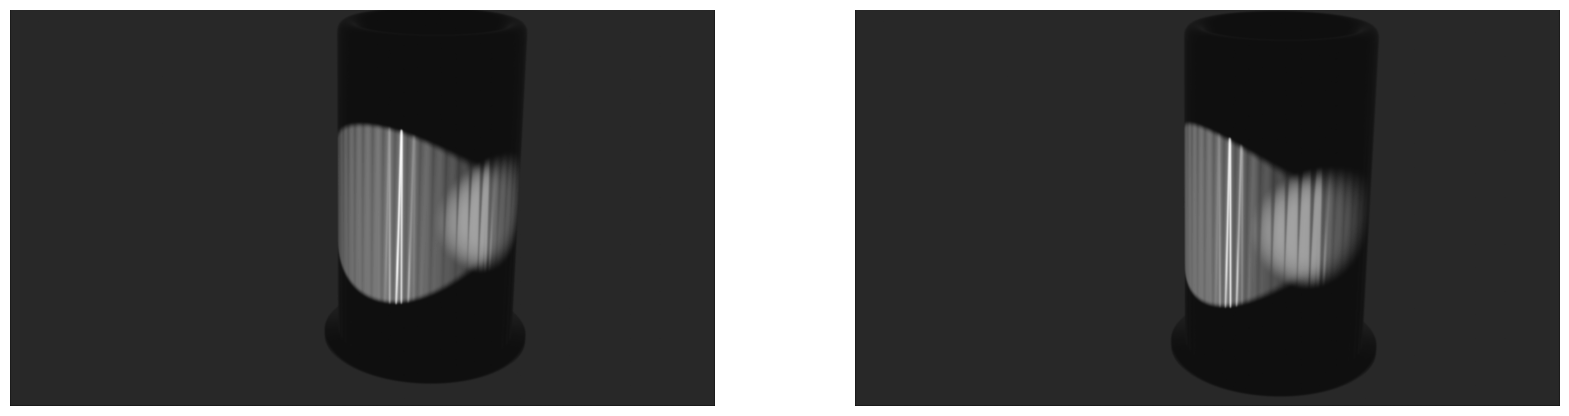

Image 1 min: 0.09196342582269723
Image 1 max: 0.9776061161702597
Image 1 mean: 0.23997968961011537
Image 1 std: 0.08418748223758696
Image 1 shape: (1080, 1920)
Image 1 dtype: float64
Image 1 size: 2073600

Image 2 min: 0.09369316330965471
Image 2 max: 0.944253025016627
Image 2 mean: 0.23682859364011355
Image 2 std: 0.08383090455693598
Image 2 shape: (1080, 1920)
Image 2 dtype: float64
Image 2 size: 2073600



In [2]:
img_folder = "../data/blender"
im_name1 = "cylinder_left"
im_name2 = "cylinder_right"
im_names = [im_name1, im_name2]
im_ext = "png"

ims = [
    cv.imread(f"{img_folder}/{im_names[i]}.{im_ext}", cv.IMREAD_GRAYSCALE)
    for i in range(2)
]


# compute float32 versions for calculations
float_ims = [vh.convert_uint8_to_float32(ims[i]) for i in range(2)]

# blur images

# blur images
float_ims = [float_ims[0], float_ims[1]]
blur_sigma = 1.6
float_ims = [desc.convolve_2D_gaussian(float_ims[i], blur_sigma) for i in range(2)]

float_ims[0], float_ims[1] = float_ims

# compute min and max values for normalization
min_val = min(float_ims[0].min(), float_ims[1].min())
max_val = max(float_ims[0].max(), float_ims[1].max())
min_vals, max_vals = [min_val, min_val], [max_val, max_val]

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(float_ims[0], cmap="gray", vmin=min_val, vmax=max_val)
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(float_ims[1], cmap="gray", vmin=min_val, vmax=max_val)
plt.axis("off")
plt.show()

# print extrema values
for i, im in enumerate(float_ims):
    print(f"Image {i+1} min: {im.min()}")
    print(f"Image {i+1} max: {im.max()}")
    print(f"Image {i+1} mean: {im.mean()}")
    print(f"Image {i+1} std: {im.std()}")
    print(f"Image {i+1} shape: {im.shape}")
    print(f"Image {i+1} dtype: {im.dtype}")
    print(f"Image {i+1} size: {im.size}")
    print("")

## Crop object


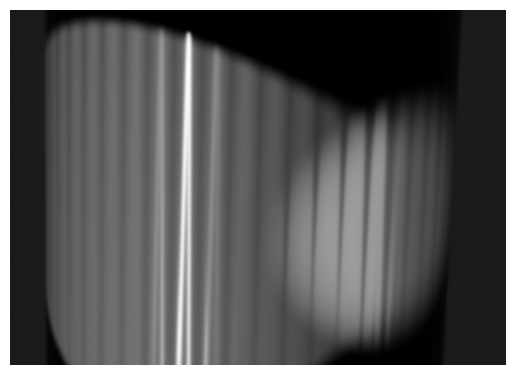

In [17]:
# crop subimage around the object
obj_ims[0]
 = float_ims[0][300:730, 850:1450]

plt.imshow(obj_ims[0]
, cmap="gray")
plt.axis("off")
plt.show()

## Compute features and descriptor for all pixels


In [18]:
obj_features1 = desc.compute_features_overall_abs(obj_ims[0], border_size=1)

In [8]:
len(obj_features1)

4

In [28]:
# define descriptor parameter
nb_bins = 3
bin_radius = 2
delta_angle = 5.0
nb_angular_bins = int(360 / delta_angle) + 1
sigma_weight = 0
normalization_mode = "global"
descriptor_size = 3 * nb_bins * nb_bins * nb_angular_bins

# define where to compute descriptor, depends on the size of the descriptor neighborhood
neighborhood_width = nb_bins * (2 * bin_radius + 1)
neighborhood_radius = neighborhood_width // 2
border_size = neighborhood_radius + 1

y_start, y_stop = border_size, obj_ims[0]
.shape[0] - border_size
x_start, x_stop = border_size, obj_ims[0]
.shape[1] - border_size

# initialize descriptor array, coordinates are in the whole image
descs_obj1 = np.zeros(
    (obj_ims[0]
.shape[0], obj_ims[0]
.shape[1], descriptor_size), dtype=np.float32
)

In [30]:
print("y_start", y_start)
print("y_stop", y_stop)
print("x_start", x_start)
print("x_stop", x_stop)

y_start 8
y_stop 422
x_start 8
x_stop 592


Find thresholds to prefilter pixels


In [20]:
_, abs_eigvals, gradients_norms, _ = obj_features1
# coordinates are in the whole image

# print statistics about the eigenvalues and gradients
print(f"Eigenvalues min: {abs_eigvals.min()}")
print(f"Eigenvalues max: {abs_eigvals.max()}")
print(f"Eigenvalues mean: {abs_eigvals.mean()}")
print(f"Eigenvalues std: {abs_eigvals.std()}")
print(f"Eigenvalues shape: {abs_eigvals.shape}")
print(f"Eigenvalues dtype: {abs_eigvals.dtype}")
print(f"Eigenvalues size: {abs_eigvals.size}")
print("")
print(f"Gradients min: {gradients_norms.min()}")
print(f"Gradients max: {gradients_norms.max()}")
print(f"Gradients mean: {gradients_norms.mean()}")
print(f"Gradients std: {gradients_norms.std()}")
print(f"Gradients shape: {gradients_norms.shape}")
print(f"Gradients dtype: {gradients_norms.dtype}")
print(f"Gradients size: {gradients_norms.size}")

Eigenvalues min: 0.0
Eigenvalues max: 0.08591726422309875
Eigenvalues mean: 0.0014471951872110367
Eigenvalues std: 0.004720550961792469
Eigenvalues shape: (430, 600, 2)
Eigenvalues dtype: float32
Eigenvalues size: 516000

Gradients min: 0.0
Gradients max: 0.3211025893688202
Gradients mean: 0.014295896515250206
Gradients std: 0.025036707520484924
Gradients shape: (430, 600)
Gradients dtype: float32
Gradients size: 258000


Define thresholds for gradient norm and curvature absolute value


In [53]:
grad_norm_thresh = gradients_norms.max() * 0.0
curv_threshs = [abs_eigvals[:, :, eigval_id].max() * 0.0 for eigval_id in range(2)]

print(f"Gradient norm threshold: {grad_norm_thresh}")
print(f"Curvature thresholds: {curv_threshs}")

Gradient norm threshold: 0.0
Curvature thresholds: [0.0, 0.0]


In [54]:
selected_keypoints = np.zeros((obj_ims[0].shape[0], obj_ims[0].shape[1]), dtype=bool)


for i in range(y_start, y_stop):
    for j in range(x_start, x_stop):
        # check if pixels chars pass thresholds

        # pixels indices are in the whole image

        is_accepted = gradients_norms[i, j] > grad_norm_thresh and all(
            abs_eigvals[i, j, eigval_id] > curv_threshs[eigval_id]
            for eigval_id in range(2)
        )

        if is_accepted:
            selected_keypoints[i, j] = True

            print(f"Accepted pixel at ({i}, {j})")

            raw_desc = desc.compute_descriptor_histograms_1_2_rotated(
                obj_features1,
                (i, j),
                nb_bins,
                bin_radius,
                delta_angle,
                sigma_weight,
                normalization_mode,
            )

            flat_desc = desc.flatten_descriptor(raw_desc)

            descs_obj1[i, j] = flat_desc

Accepted pixel at (8, 8)
Accepted pixel at (8, 9)
Accepted pixel at (8, 10)
Accepted pixel at (8, 11)
Accepted pixel at (8, 12)
Accepted pixel at (8, 13)
Accepted pixel at (8, 14)
Accepted pixel at (8, 15)
Accepted pixel at (8, 16)
Accepted pixel at (8, 17)
Accepted pixel at (8, 18)
Accepted pixel at (8, 19)
Accepted pixel at (8, 20)
Accepted pixel at (8, 21)
Accepted pixel at (8, 22)
Accepted pixel at (8, 23)
Accepted pixel at (8, 24)
Accepted pixel at (8, 25)
Accepted pixel at (8, 26)
Accepted pixel at (8, 27)
Accepted pixel at (8, 28)
Accepted pixel at (8, 29)
Accepted pixel at (8, 30)
Accepted pixel at (8, 31)
Accepted pixel at (8, 32)
Accepted pixel at (8, 33)
Accepted pixel at (8, 34)
Accepted pixel at (8, 35)
Accepted pixel at (8, 36)
Accepted pixel at (8, 37)
Accepted pixel at (8, 38)
Accepted pixel at (8, 39)
Accepted pixel at (8, 40)
Accepted pixel at (8, 41)
Accepted pixel at (8, 42)
Accepted pixel at (8, 43)
Accepted pixel at (8, 44)
Accepted pixel at (8, 45)
Accepted pixel

KeyboardInterrupt: 

In [51]:
print(f"Number of selected pixels: {sum(sum(selected_keypoints))}")

Number of selected pixels: 14


Display found keypoints on object image


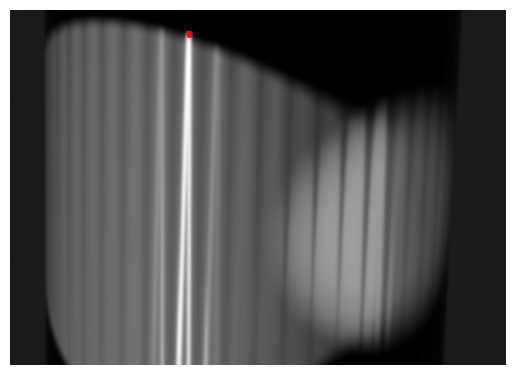

In [52]:
plt.imshow(obj_ims[0], cmap="gray")



plt.axis("off")



plt.scatter(

    np.where(selected_keypoints)[1], np.where(selected_keypoints)[0], c="r", s=1
)



plt.show()

Selection results:

- no threshold: too long computations for my laptop (>16')
- grad_threshold = mean, eigval1_threshold = mean, eigval2_threshold = mean
  - 989 keypoints
- grad_threshold = max \* 0.5, eigval1_threshold = mean, eigval2_threshold = mean
  - 126 keypoints
- grad_threshold = max \* 0.5, eigval1_threshold = max \* 0.3, eigval2_threshold = max \* 0.3
  - 12 keypoints -> all concentrated on the top white line
- grad_threshold = 0, eigval1_threshold = max \* 0.3, eigval2_threshold = max \* 0.3
  - 14 keypoints -> all concentrated on the top white line

Observations:

- a brut threshold on either gradient or curvature kills too much keypoints
